In [1]:
# required Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math 
import torch

import pathlib   
import pytesseract

%matplotlib inline
temp = pathlib.PosixPath  
pathlib.PosixPath = pathlib.WindowsPath
config = r'--oem 3 --psm 6'
pytesseract.pytesseract.tesseract_cmd=r"C:\Program Files\Tesseract-OCR\tesseract.exe"


In [2]:
fog_image= r'Test Images/WhatsApp Image 2024-04-26 at 08.21.35.jpeg'
path_2=  r'Test Images/IMG-20230220-WA0018.jpg'
path_3 = r'Test Images/IMG-20230220-WA0018.jpg '
path_4 =  r'Test Images/WhatsApp Image 2024-04-24 at 07.42.24.jpeg'
path_5=  r'Test Images/WhatsApp Image 2024-04-24 at 07.42.25.jpeg'
path_6=  r'Test Images/WhatsApp Image 2024-04-26 at 08.13.57.jpeg'
path_7 = r'Test Images/WhatsApp Image 2024-04-26 at 08.14.00 (1).jpeg'
Path_8= r'Test Images/WhatsApp Image 2024-04-26 at 08.14.00 (2).jpeg'
path_9= r'Test Images/WhatsApp Image 2024-04-26 at 08.14.00.jpeg'

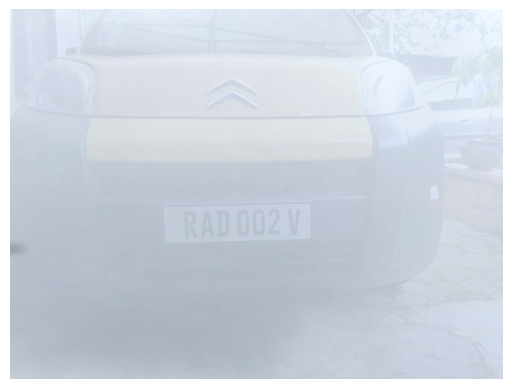

In [6]:
# import image

# read image
haze_image = cv2.imread(fog_image)
test1 = cv2.imread(path_2)
test2 = cv2.imread(path_3)
test3 = cv2.imread(path_4)
test4=cv2.imread(path_5)
test5=cv2.imread(path_6)
test6=cv2.imread(path_7)
test7=cv2.imread(Path_8)
test8=cv2.imread(path_9)


# convert the image into proper channel
image = cv2.cvtColor(haze_image,cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(test1,cv2.COLOR_BGR2RGB)
image_3= cv2.cvtColor(test2,cv2.COLOR_BGR2RGB)
image_4= cv2.cvtColor(test3,cv2.COLOR_BGR2RGB)
image_5= cv2.cvtColor(test4,cv2.COLOR_BGR2RGB)
image_6= cv2.cvtColor(test5,cv2.COLOR_BGR2RGB)
image_7= cv2.cvtColor(test6,cv2.COLOR_BGR2RGB)
image_8= cv2.cvtColor(test7,cv2.COLOR_BGR2RGB)
image_9= cv2.cvtColor(test8,cv2.COLOR_BGR2RGB)

height= image_8.shape[0]
width= image_8.shape[1]
# resize the image 
resize = cv2.resize(image,(width,height), interpolation=cv2.INTER_NEAREST)
result = cv2.addWeighted(image_8, 0.1, resize , 0.95,0)
plt.imshow(result)
# plt.savefig('merged10.jpg')
plt.axis('off')
plt.show()

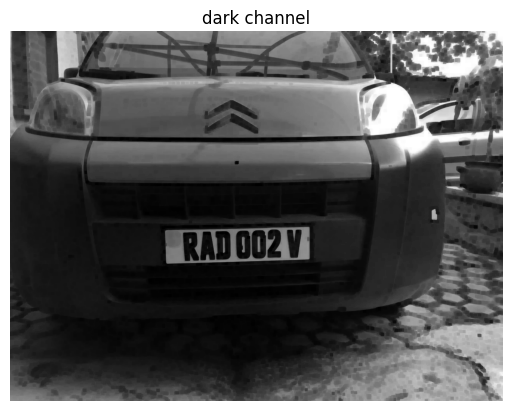

In [7]:
# get dark pixels from the images
def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

# imag_float = result.astype('float') /255
imag_float = image_8.astype('float') /255
plt.imshow(DarkChannel(imag_float ,7),cmap='gray')
plt.title('dark channel')
plt.axis('off')
# plt.savefig('dark channel image_test 3.jpg')
plt.show()


In [8]:
# get atmlight
def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/100),1))
    darkvec = dark.reshape(imsz)
    imvec = im.reshape(imsz,3)

    indices = darkvec.argsort()
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx
    return A
A = AtmLight(imag_float , DarkChannel(imag_float,15))

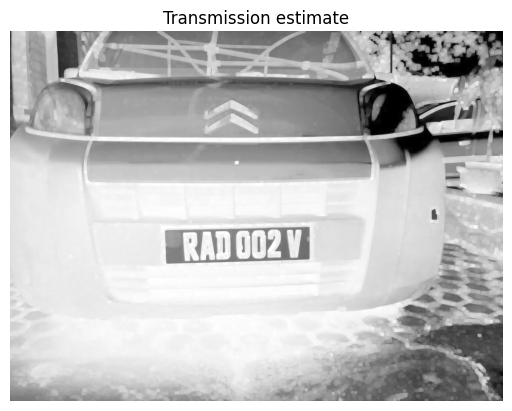

In [9]:
def TransmissionEstimate(im,A,sz):
    omega = 0.95
    im3 = np.empty(im.shape,im.dtype)

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz)
    return transmission

transimission = TransmissionEstimate(imag_float,A,7)
plt.imshow(transimission,cmap ='gray')
plt.title('Transmission estimate')
plt.axis('off')
# plt.savefig('transmission  estimate image test_1.jpg')
plt.show()


In [10]:
def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r))
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r))
    cov_Ip = mean_Ip - mean_I*mean_p

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
    var_I   = mean_II - mean_I*mean_I

    a = cov_Ip/(var_I + eps)
    b = mean_p - a*mean_I

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r))
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r))

    q = mean_a*im + mean_b
    return q


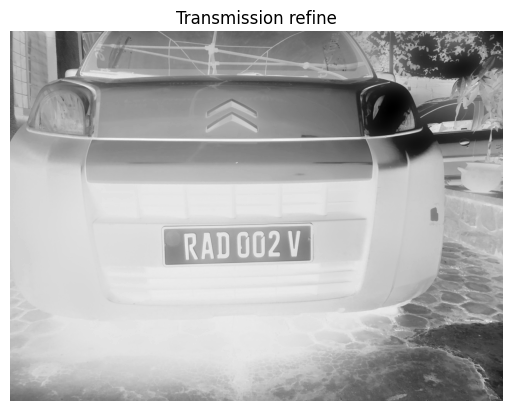

In [11]:
def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    gray = np.float64(gray)/255
    r = 60
    eps = 0.0001
    t = Guidedfilter(gray,et,r,eps)

    return t
t =TransmissionRefine(image_8, transimission)
plt.imshow(t,cmap ='gray')
plt.title('Transmission refine')
plt.axis('off')
# plt.savefig('transimission_refine test 5.jpg')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


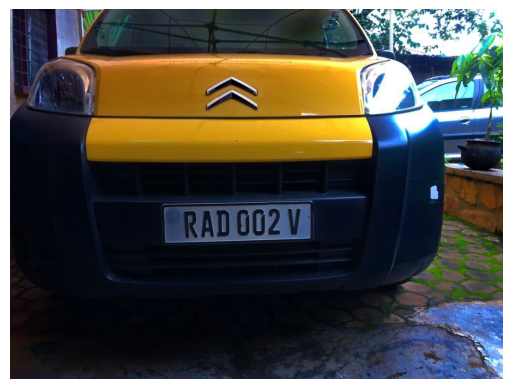

In [12]:
def Recover(im,t,A,tx ):
    res = np.empty(im.shape,im.dtype)
    t = cv2.max(t,tx)

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res

dehazed_image = Recover(imag_float , t, A, 0.1)

plt.imshow(dehazed_image,cmap ='gray')
plt.axis('off')
# plt.savefig('refined_60.jpg')
plt.show()


In [13]:
# clone model anf upload pretrained weighta
model = torch.hub.load('ultralytics/yolov5', 'custom', path='best.pt', force_reload=True)

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to C:\Users\Loaner13/.cache\torch\hub\master.zip
YOLOv5  2024-4-27 Python-3.12.2 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Image loaded successfully!
(480, 640, 3)


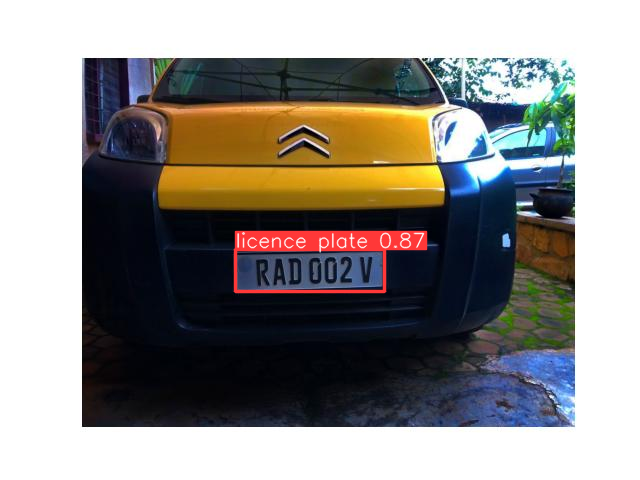

In [14]:
device = 'cpu'
model.to(device)
try:
    image = cv2.imread('refined_58.jpg')
    image =cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image loaded successfully!")
except IOError:
    print("Image could not be opened. Please check the file path and ensure the image is not corrupted.")
# Convert to a format the model can handle
img = np.array(image)
# Convert to numpy array if not already
img = img[..., :3] if img.shape[2] > 3 else img 
results = model(img, size=640)  
print(img.shape)
results.show() 
# results.save('saved_detected.jpg')# uncomment if need to save image

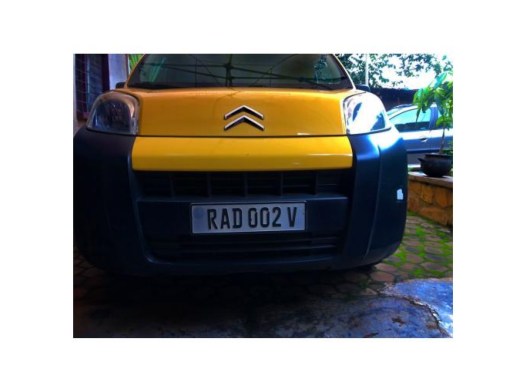

In [15]:
# Read image
image = cv2.imread('refined_58.jpg')
# convert image
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
# upscaled = sr.upsample(image)
%matplotlib inline
plt.imshow(image)
plt.axis('off')
plt.show()

In [16]:
# extrac the bounding boxes
bbox = results.xyxy[0][0]
bbox_array=[]
for i in bbox[:4]:
    bbox_array.append(int(i.item()))
bbox_array

[235, 249, 384, 291]

(480, 640, 3)


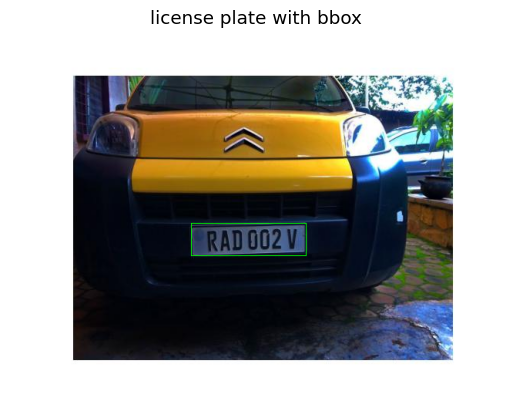

In [17]:
# copy image 
new_image= image.copy()
print(new_image.shape)
# new_image=cv2.resize(new_image,(640,480))
height, width = image.shape[:2]
cv2.rectangle(new_image,(bbox_array[0],bbox_array[1]),(bbox_array[2],bbox_array[3]),(0,255,0),1)
%matplotlib inline
plt.imshow(new_image)
plt.axis('off')
plt.title('license plate with bbox')
plt.savefig('license with bbox1.jpg')
plt.show()

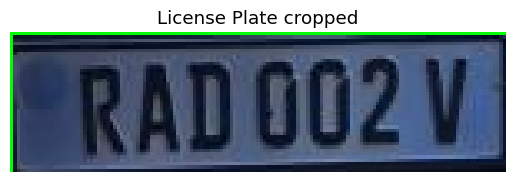

In [18]:
# # cropp the image with the license plate
image_cropped = new_image.copy()
image_cropped = image_cropped[bbox_array[1]:bbox_array[3], bbox_array[0]:bbox_array[2]]
%matplotlib inline
plt.imshow(image_cropped)
plt.title('License Plate cropped')
plt.axis('off')
# plt.savefig('cropped.jpg')
plt.show()


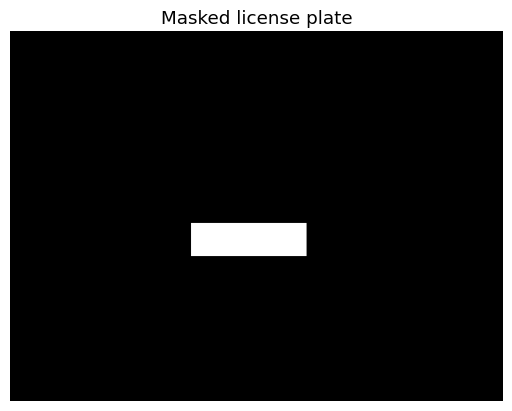

In [19]:
mask = image.copy()
mask[:, :] = (0, 0, 0)
cv2.rectangle(mask,(bbox_array[0],bbox_array[1]),(bbox_array[2],bbox_array[3]),(255,255,255),-1)
plt.imshow(mask)
plt.title('Masked license plate')
plt.axis('off')
plt.show()

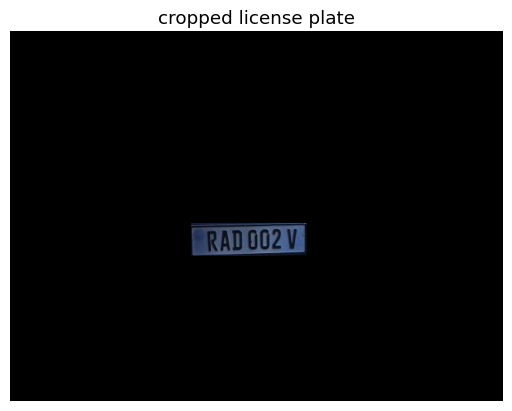

In [20]:
plate_only = cv2.bitwise_and(image, mask)

plt.imshow(plate_only)
plt.axis('off')
plt.title('cropped license plate')
# plt.savefig('saved cropped11.jpg')
plt.show()



In [21]:
# # enhanced_plate = cv2.convertScaleAbs(plate_only, alpha=1.2, beta=30)
    
# #     # Convert the enhanced plate region to grayscale
# gray_plate = cv2.cvtColor(plate_only, cv2.COLOR_BGR2GRAY)
    
# #     # Apply histogram equalization to enhance contrast
# # equalized_plate = cv2.equalizeHist(gray_plate)

# # kernel = np.ones((1, 1), np.uint8)
# # img = cv2.dilate(gray_plate, kernel, iterations=1)
# # img = cv2.erode(img, kernel, iterations=1)

    
# # Apply Gaussian blur to reduce noise
# blurred_plate = cv2.GaussianBlur(gray_plate, (1, 1), 0)
    
# # Apply adaptive thresholding to segment the license plate region
# _, thresh_plate = cv2.threshold(blurred_plate, 0, 255,  cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# ocr_text = pytesseract.image_to_string(thresh_plate, config=config)
        
#         # Check if the OCR result contains alphanumeric characters
# if any(char.isalnum() for char in ocr_text):
#             # Save the refined license plate region as a separate image
#             # plate_filename = os.path.join(output_dir, f'plate_{i+1}.jpg')
#             # cv2.imwrite(plate_filename, rotated_plate_region)
#         print(f"Plate {i+1} saved. OCR Text: '{ocr_text}'")
# else:
#         print(f"No alphanumeric characters found in Plate {i+1}. OCR Text: '{ocr_text}'")


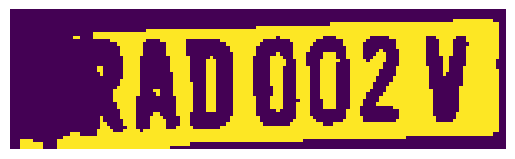

Plate 1 saved. OCR Text: 'RADOO2V
'


In [22]:

# Load the original image
image = cv2.imread('refined_58.jpg')


# Accessing bounding box predictions
bboxes = results.xyxy[0].cpu().numpy()  

# Initialize Pytesseract OCR engine
# pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Update this path accordingly
# config = r'--oem 3 --psm 6'  # OCR configuration options

# Iterate over bounding box predictions
for i, bbox in enumerate(bboxes):
    x_min, y_min, x_max, y_max, confidence = bbox[:5]  # Extract bounding box coordinates
    
    # Extract region defined by bounding box (license plate region)
    plate_region = image[int(y_min):int(y_max), int(x_min):int(x_max)]
    
    # Enhance the license plate region with brightness adjustment
    enhanced_plate = cv2.convertScaleAbs(plate_region, alpha=1.1, beta=30)
    
    # Convert the enhanced plate region to grayscale
    gray_plate = cv2.cvtColor(enhanced_plate, cv2.COLOR_BGR2GRAY)
    
    # Apply histogram equalization to enhance contrasta
    equalized_plate = cv2.equalizeHist(gray_plate)
    
    # Apply Gaussian blur to reduce noise
    blurred_plate = cv2.GaussianBlur(equalized_plate, (5, 5), 0)
    
    # Apply adaptive thresholding to segment the license plate region
    _, thresh_plate = cv2.threshold(blurred_plate, 0, 255,  cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    plt.imshow(thresh_plate)
    plt.axis('off')
    plt.show()
    
    # Find contours in the thresholded image
    contours_plate, _ = cv2.findContours(thresh_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the contour with the largest area among contours
    max_contour_plate = max(contours_plate, key=cv2.contourArea) if contours_plate else None
   
    # Ensure the contour exists and has sufficient area
    if max_contour_plate is not None and cv2.contourArea(max_contour_plate) > 100:
        # Get the bounding box of the contour
        x_plate, y_plate, w_plate, h_plate = cv2.boundingRect(max_contour_plate)
        
        # Expand the bounding box slightly to ensure the license plate is fully enclosed
        x_plate -= 5
        y_plate -= 5
        w_plate += 10
        h_plate += 10
        
        # Ensure the bounding box stays within the image boundaries
        x_plate = max(0, x_plate)
        y_plate = max(0, y_plate)
        w_plate = min(w_plate, plate_region.shape[1])
        h_plate = min(h_plate, plate_region.shape[0])
        
        # Extract the refined license plate region using the adjusted bounding box
        refined_plate_region = plate_region[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]
        
        # Rotate the plate region to zero degrees
        angle = 0  # Angle in degrees (counter-clockwise rotation)
        (h, w) = refined_plate_region.shape[:2]
        center = (w // 2, h // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
        rotated_plate_region = cv2.warpAffine(refined_plate_region, rotation_matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
        
        # Perform OCR on the rotated license plate region
        ocr_text = pytesseract.image_to_string(rotated_plate_region, config=config)
        
        # Check if the OCR result contains alphanumeric characters
        if any(char.isalnum() for char in ocr_text):
            # Save the refined license plate region as a separate image
            # plate_filename = os.path.join(output_dir, f'plate_{i+1}.jpg')
            # cv2.imwrite(plate_filename, rotated_plate_region)
            print(f"Plate {i+1} saved. OCR Text: '{ocr_text}'")
        else:
            print(f"No alphanumeric characters found in Plate {i+1}. OCR Text: '{ocr_text}'")
    else:
        print(f"No contours found for Plate {i+1}")

# Notify when extraction is complete
# print("License plate segmentation complete. Rotated and refined plate regions saved in:", output_dir)

In [41]:
# get ocr text and strip it 

char= []
score= 0
result=[]
true_labels = ['RAD002V']
char.append(ocr_text.strip())
# print(char)
i = 0
while True:
    if i < len(true_labels):  
        plate = char[i]
        true = true_labels[i]
        for x, y in zip(plate, true):
            if x == y:
                score += 1  
            
            else:
                score -= 1 
        result.append(score) 
        i += 1
    else:
        break 

total_scores=[]
for i in range(len(true_labels)):
    total_score = (result[i]*100) / int(len(true_labels[i]))

total_scores.append(total_score)

# noneho wacreating graphs 

42.857142857142854

In [27]:
# generate graph

'RAD002V'